# **Measure your PLR and PIPR with *PyPlr*!**
This notebook shows how to measure and visualise your **pupil light response (PLR)** and **post-illumination pupil response (PIPR)** using *PyPlr*. 

The PLR is the rapid constriction of the pupil that follows an increase in retinal illumination. It is a biological mechanism that serves to enhance visual acuity by regulating both the amount and the trajectory of light that strikes the retinae, and perhaps also to protect the retinal photoreceptors from damaging levels of illumination. The PIPR is the sustained constriction of the pupil that follows exposure specifically to short wavelength light. Whereas all light sensitive cells contribute to the PLR, the PIPR is mediated specifically by the **intrinsically photosensitive retinal ganlglion cells (ipRGCs)**, which express the photopigment **melanopsin**. 

In [1]:
import sys
sys.path.insert(0, '../../')
from time import sleep#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyplr import stlab

In [2]:
d = stlab.STLAB(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete.


# Making stimuli
The goal is to create two light pulses that differentially excite melanopsin, but are matched for overall radiance. We know that channel 4 of the STLAB has the highest melanopic irradiance and that channel 9 has virtually zero. So we can start by creating a blue light with an intensity that is comfortable enough to endure for 1s. Then we load the lookup table created from the Ocean Optics spectrometer data which predicts the output of all leds at all intensity settings. Passing this to the `stlab.led_radiance_match(...)` function we get the required intensity that channel 9 (dark red) needs to be in order to match channel 4 (blue) at intensity=2000. Finally, we pass these values to `stlab.pulse_protocol(...)` to generate the video files.

In [2]:
blue = [0, 0, 0, 2500, 0, 0, 0, 0, 0, 0]
lkp_tbl = pd.read_csv('../data/corrected_oo_lookup_table.csv', 
                      index_col=['led','intensity'])
red_match = stlab.led_radiance_match(led=3, 
                                     intensity=2500, 
                                     match_led=9, 
                                     lkp_tbl=lkp_tbl)
red  = [0, 0, 0, 0, 0, 0, 0, 0, 0, red_match[1]]
stlab.pulse_protocol(pulse_spec=blue,
                     pulse_duration=1000, 
                     fname='1s_blue',
                     metadata={'color':'blue'})
stlab.pulse_protocol(pulse_spec=red, 
                     pulse_duration=1000, 
                     fname='1s_red',
                     metadata={'color':'red'})

"1s_blue.dsf" saved in the current working directory.
"1s_red.dsf" saved in the current working directory.


In [3]:
red_match

(0.00015233965594063648, 1979)

Let's visualise the stimuli with the melanopsin spectral sensitivity curve

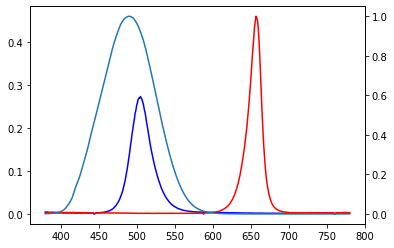

In [4]:
from pyplr.CIE import get_CIES026
_ , cies = get_CIES026(asdf=True)

f, ax = plt.subplots()
wls = lkp_tbl.columns.to_numpy().astype('float')

ax.plot(wls, lkp_tbl.loc[(4,2000)], c='blue')
ax.plot(wls, lkp_tbl.loc[(9,red_match[1])], c='red')
    
ax2 = ax.twinx()
ax2.plot(wls, cies["Mel"])

# Setting up the experiment

In [31]:
import random
import os
recdir = os.getcwd()

# prepare stims
stims = ['blue.dsf', 'red.dsf'] * 3
random.shuffle(stims)
stims

['red.dsf', 'blue.dsf', 'blue.dsf', 'red.dsf', 'blue.dsf', 'red.dsf']

# Running the experiment

To see a maximal effect of melanopsin, dark adapt for 10 mins.

In [ ]:
# connect to Pupil Core
p = PupilCore()

# connect to stlab
d = stlab.STLAB(username='admin', identity=1, password='83e47941d9e930f6')

# start recording
p.command('R {}'.format(os.getcwd()))

# wait a few seconds so you can get in place
sleep(5.)  

# loop over the list of stims
for stim in stims:
    
    # load video file and create trigger with metadata
    vf = d.load_video_file(stim)
    trigger = {**new_trigger('LIGHT_ON'), **vf['metadata']}
    
    # baseline
    sleep(10.)
    
    # set up and start the LightStamper thread 
    lst = LighStamper(p, threshold=15, trigger=trigger, wait_time=6)
    lst.start()
    
    # wait 200 ms
    sleep(.2)
    
    # play the video file
    d.play_video_file()
    sleep(60.)  

# finish recording
sleep(5.)   
p.command('r')